In [2]:
import numpy as np
import pandas as pd
import rioxarray as rxa

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path

import skgstat as skg

from tqdm import tqdm

from itertools import product

np.random.seed(42)

# home_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/')
home_dir = Path('/bsuhome/zacharykeskinen/uavsar-coherence/')
fig_dir = home_dir.joinpath('figures', 'variograms')

uavsar_dir = Path('/bsuhome/zacharykeskinen/scratch/coherence/uavsar/tiffs/')

# get list of uavsars directories
uavsars = list(uavsar_dir.glob('*')) # sorted
# get only one site
# uavsars = [u for u in uavsars if u.stem.split('_')[0] == 'lowman']
# get location and flight direction for key and first coherence tiff as value of dictionary
uavsars = {u.stem: list(u.glob('*.cor.grd.tiff')) for u in uavsars if len(list(u.glob('*.cor.grd.tiff'))) > 0}

# figure out max and min dt
max_dt = 0
min_dt = 100
for uavsar, fps in uavsars.copy().items():
    fp = fps[0]
    ann = pd.read_csv(list(fp.parent.glob('*.csv'))[0], index_col = 0)
    t1, t2 = ann.loc['value', 'start time of acquisition for pass 1'], ann.loc['value', 'start time of acquisition for pass 2']
    t1, t2 = [pd.to_datetime(t) for t in [t1, t2]]
    dt = t2 - t1
    if dt.days > 100: uavsars.pop(uavsar); continue
    if dt.days < 2: uavsars.pop(uavsar); continue
    if dt.days > max_dt: max_dt = dt.days
    if dt.days < min_dt: min_dt = dt.days

cmap = mpl.colormaps.get_cmap('plasma')
norm = mpl.colors.Normalize(min_dt, max_dt)

In [81]:
loc_colors = {'grmesa': {'color': 'mediumspringgreen', 'name': 'Grand Mesa, CO'}, 'stlake': {'color': 'mediumseagreen', 'name': 'St. Lake, UT'}, 'rockmt': {'color': 'orange', 'name': 'Rocky Mountain NP, CO'}, \
    'irnton': {'color':'darkorchid', 'name': 'Ironton, CO'}, 'sierra': {'color':'lightskyblue', 'name':'Sierra, CA'}, 'fraser': {'color':'cornflowerblue','name': 'Fraser, CO'}, \
        'lowman': {'color': 'pink', 'name': 'Lowman, ID'}, 'silver': {'color': 'darkgoldenrod', 'name': 'Reynold Creek, ID'}, 'uticam': {'color':'goldenrod', 'name': 'Uticam, MT'}, 'peeler': {'color': 'indianred', 'name':'Peeler, CO'},\
        'alamos': {'color': 'magenta', 'name': 'Alamos, NM'}, 'donner': {'color': 'mediumturquoise', 'name': 'Donner, CA'}, 'dorado': {'color': 'slategrey', 'name': 'Dorado, CA'}}
fig, axes = plt.subplots(2, 3, figsize = (12, 8))

for loc, d in loc_colors.items():
    # if loc != 'grmesa' and loc != 'alamos' and loc != 'silver' and 'loc' != 'stlake': continue
    print(loc)
    color, name = d['color'], d['name']
    loc_coords, loc_values = np.array([[],[]]).T, np.array([])

    loc_uavsars = {k:v for k,v in uavsars.items() if loc in k}
    
    for i, (uavsar, fps) in enumerate(tqdm(loc_uavsars.items())):
        if i > 3: continue

        fps = [fp for fp in fps if 'HH_' in fp.stem]
        if len(fps) != 1: continue
        fp = fps[0]

        locs = uavsar.split('_')[0]
        
        img = rxa.open_rasterio(fp).squeeze('band', drop = True)
        img = img.rio.write_crs('EPSG:4326').rio.reproject(dst_crs = img.rio.estimate_utm_crs())
        img = img.where((img > 0) & (img < 1))
        # crop out center 10km
        img = img.sel(x = slice(img.x.mean() - 5000, img.x.mean() + 5000), y = slice(img.y.mean() + 5000, img.y.mean() - 5000))
        img = img.dropna('x', how = 'all').dropna('y', how = 'all')

        n_samples = 100
        coords = list(product(np.random.choice(img.x, round(n_samples**0.5)), np.random.choice(img.y, round(n_samples**0.5))))
        values = np.array([img.sel(x = x, y = y).values for x, y in coords]).ravel()
        coords, values = np.array(coords)[~np.isnan(values)], values[~np.isnan(values)]
        loc_coords = np.concatenate([loc_coords, coords])
        loc_values = np.concatenate([loc_values, values])

    ax = axes.ravel()[0]
    V = skg.Variogram(loc_coords, loc_values, n_lags = 100, bin_func = 'uniform', use_nugget = True, model = 'exponential', maxlag = 5000) # maxlag = 20000, n_lags = 100,
    V.plot(axes = ax, grid = False, show = False, hist = False)
    [l.set_color(color) for l in ax.get_lines()[-2:]]
    ax.plot([], [], color = color, label = name, alpha = 1)


for ax in axes.ravel():
    [l.set_linestyle('--') for l in ax.get_lines()[1::2]]
    [l.set_visible(False) for l in ax.get_lines()[::2]]

axes[0, 0].legend(ncols = 1)

fig.savefig(fig_dir.joinpath('variograms.png'))


grmesa


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


stlake


100%|██████████| 21/21 [00:05<00:00,  4.10it/s]


rockmt


100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


irnton


100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


sierra


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


fraser


  6%|▋         | 1/16 [00:03<00:47,  3.15s/it]

Starting...


 26%|██▋       | 5/19 [01:19<03:42, 15.91s/it]


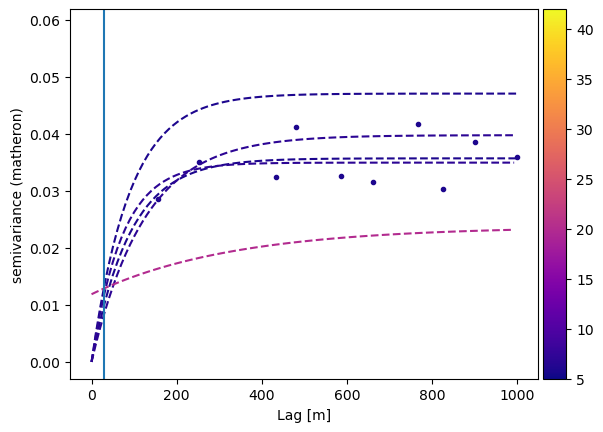

In [37]:
from pathlib import Path

import numpy as np
import pandas as pd

import rioxarray as rxa

import matplotlib as mpl
import matplotlib.pyplot as plt


import skgstat as skg

from tqdm import tqdm

from itertools import product

np.random.seed(42)

print('Starting...')
home_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/')
home_dir = Path('/bsuhome/zacharykeskinen/uavsar-coherence/')
fig_dir = home_dir.joinpath('figures', 'variograms')

uavsar_dir = Path('/bsuhome/zacharykeskinen/scratch/coherence/uavsar/tiffs/')

# get list of uavsars directories
uavsars = list(uavsar_dir.glob('*')) # sorted
import random
random.shuffle(uavsars)
# remove tmp dir
uavsars = [u for u in uavsars if u.stem.split('_')[0] == 'lowman']
# get location and flight direction for key and first coherence tiff as value of dictionary
uavsars = {u.stem: list(u.glob('*.cor.grd.tiff'))[0] for u in uavsars if len(list(u.glob('*.cor.grd.tiff'))) > 0}

n = 1000
fig, axes = plt.subplots(1, 1)
axes = [axes]
locs = []

max_dt = 0
min_dt = 100
for uavsar, fp in uavsars.items():
    ann = pd.read_csv(list(fp.parent.glob('*.csv'))[0], index_col = 0)
    t1, t2 = ann.loc['value', 'start time of acquisition for pass 1'], ann.loc['value', 'start time of acquisition for pass 2']
    t1, t2 = [pd.to_datetime(t) for t in [t1, t2]]
    dt = t2 - t1
    if dt.days > max_dt: max_dt = dt.days
    if dt.days < min_dt: min_dt = dt.days

cmap = mpl.colormaps.get_cmap('plasma')
norm = mpl.colors.Normalize(min_dt, max_dt)

for i, (uavsar, fp) in tqdm(enumerate(uavsars.items()), total = len(uavsars)):
    # if uavsar.split('_')[0] in locs: continue
    # locs.append(uavsar.split('_')[0])

    if i == 5: break

    ann = pd.read_csv(list(fp.parent.glob('*.csv'))[0], index_col = 0)
    t1, t2 = ann.loc['value', 'start time of acquisition for pass 1'], ann.loc['value', 'start time of acquisition for pass 2']
    t1, t2 = [pd.to_datetime(t) for t in [t1, t2]]
    dt = t2 - t1

    img = rxa.open_rasterio(fp).squeeze('band', drop = True)
    img = img.rio.write_crs('EPSG:4326').rio.reproject(dst_crs = img.rio.estimate_utm_crs())
    img = img.where((img > 0) & (img < 1))
    # crop out center 5km
    img = img.sel(x = slice(img.x.mean() - 2500, img.x.mean() + 2500), y = slice(img.y.mean() + 2500, img.y.mean() - 2500))
    img = img.dropna('x', how = 'all').dropna('y', how = 'all')
    coords = list(product(np.random.choice(img.x, 10), np.random.choice(img.y, 10)))
    values = np.array([img.sel(x = x, y = y).values for x, y in coords]).ravel()
    coords = np.array(coords)[~np.isnan(values)]
    values = values[~np.isnan(values)]



    V = skg.Variogram(coords, values, n_lags = 10, bin_func = 'uniform', use_nugget = True, model = 'exponential', maxlag = 1000) # maxlag = 20000, n_lags = 100,
    V.plot(axes = axes[0], grid = False, show = False, hist = False)
    ax = axes[0]
    [l.set_color(cmap(norm(dt.days))) for l in ax.get_lines()[-2:]]

    # V = skg.Variogram(coords, values, n_lags = 10, bin_func = 'uniform', use_nugget = True, model = 'exponential', maxlag = 100) # maxlag = 20000, n_lags = 100,
    # V.plot(axes = axes[1], grid = False, show = False, hist = False)
    # V.distance_difference_plot()

axes[0].set_xlabel('')
axes[0].set_xlabel('Lag [m]')

for ax in axes:
    # [l.set_color("black") for l in ax.get_lines()]
    [l.set_linestyle('--') for l in ax.get_lines()[1::2]]
    [l.set_visible(False) for l in ax.get_lines()[2::2]]
    ax.axvline(30)

ax = axes[0]
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
